<a href="https://colab.research.google.com/github/pdoren/analisis-estadistico-con-Python-G105/blob/main/Desaf%C3%ADo_Preparacion_de_datos_y_graficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Preparación de datos y gráficos

**Nombre**: Pablo Saavedra <br />
**Curso**: Análisis estadístico con Python (G105)


---



Carga de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.impute import SimpleImputer

pd.options.display.float_format = "{:,.2f}".format   # Visualizar 2 decimales

def print_outliers(_df: pd.DataFrame, _cols: list,
                 _k: float=1.5, col_index: str='Country'):
  print('Outliers:')
  for col in _cols:
    q1, q3 = _df[col].quantile([.25, .75])
    iqr = q3 - q1
    low, high = q1 - _k * iqr, q3 + _k * iqr
    mask_out = (_df[col] < low) | (_df[col] > high)
    if mask_out.any():
      print(col)
      print(_df[mask_out][[col_index, col]])

def get_outliers(_df: pd.DataFrame, _cols: list,
                 _k: float=1.5):
  ret = None
  for col in _cols:
    q1, q3 = _df[col].quantile([.25, .75])
    iqr = q3 - q1
    low, high = q1 - _k * iqr, q3 + _k * iqr
    mask_out = (_df[col] < low) | (_df[col] > high)
    if mask_out.any():
      if ret is None:
        ret = mask_out
      else:
        ret = ret | mask_out
  return ret

def escalado_robusto(_df: pd.DataFrame, _cols: list) -> pd.DataFrame:
  df2 = _df.copy()
  for col in _cols:
    q1 = df2[col].quantile(0.25)
    q3 = df2[col].quantile(0.75)
    iqr = q3 - q1
    df2[col] = (df2[col] - q1) / iqr
  return df2


La función get_outliers obtene los valores atípicos o outliers utilizando la **regla del rango intercuartil**:

Cualquier observación $x$ que satisfaga la ecuación de abajo implica que es un valor atípico o outliers.

$$ |x| > k \cdot IQR$$

Donde:
- $Q_1$, primer cuartil (25 % de los datos por debajo).
- $Q_3$, tercer cuartil (75 % de los datos por debajo).
- Contante $k$:
  - $k = 1.5$ se obtienen valores atípicos.
  - $k = 3.0$ se obtienen valores extremos.
- $IQR = 1.5 \cdot (Q_3 - Q_1)$ rango intercuartílico.

---

## 1. Carga de Datos
Carga los datos y genera un dataFrame que excluya las columnas correspondientes a la abreviatura del país, código de llamada, capital, código de moneda, ciudad más grande, lenguaje oficial, latitud y longitud. Considerando estos datos, realiza una inspección inicial sobre ellos, considerando gráficos. Concluye.

In [2]:
df_orig = pd.read_csv('/content/drive/MyDrive/world-data-2023.csv')

# Borrar columnas
df_orig = df_orig.drop(['Abbreviation', 'Calling Code', 'Capital/Major City', 'Currency-Code',
                        'Largest city', 'Official language', 'Latitude', 'Longitude'], axis=1)
df = df_orig

# Se eliminan duplicados si existen
df = df.drop_duplicates()

# Convertir campos a números reales y validar porcentajes
for campo in df.columns:
  if campo != 'Country':
    if df[campo].dtype == 'string' or df[campo].dtype == 'object':
      df[campo] = df[campo].str.replace(r'[,\$%]', '', regex=True).astype(float)

df.columns = df.columns.str.replace('\n', '')
df.columns = df.columns.str.replace('Land( %', 'Land (%')
df.columns = df.columns.str.replace('y(P', 'y (P')
df.columns = df.columns.str.replace('Area(K', 'Area (K')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density (P/Km2)                            195 non-null    float64
 2   Agricultural Land (%)                      188 non-null    float64
 3   Land Area (Km2)                            194 non-null    float64
 4   Armed Forces size                          171 non-null    float64
 5   Birth Rate                                 189 non-null    float64
 6   Co2-Emissions                              188 non-null    float64
 7   CPI                                        178 non-null    float64
 8   CPI Change (%)                             179 non-null    float64
 9   Fertility Rate                             188 non-null    float64
 10  Forested Area (%)         

> **Nota**: previamente se observó que los registros de algunas columnas contenian caracteres que no permitian convertir los registros a números. Se eliminaron esos caracteres y se realizó la conversión para poder trabajar con ellos.

Se normalizan algunas columnas

In [3]:
# Birth Rate:
# se cambia de Número de nacimientos por 1,000 habitantes por año a un porcentaje
df['Birth Rate'] = df['Birth Rate'] / 1000.0 * 100

# Infant Mortality:
# se cambia de Número de muertes por cada 1,000 nacidos vivos antes de cumplir
# un año de edad por porcentaje
df['Infant mortality'] = df['Infant mortality'] / 1000.0 * 100

# Maternal Mortality Ratio:
# Número de muertes maternas por cada 100,000 nacidos vivos por porcentaje
df['Maternal mortality ratio'] = df['Maternal mortality ratio'] / 100000.0 * 100

## 1.2 Gráficos Datos

> Plotear el histograma de los datos:

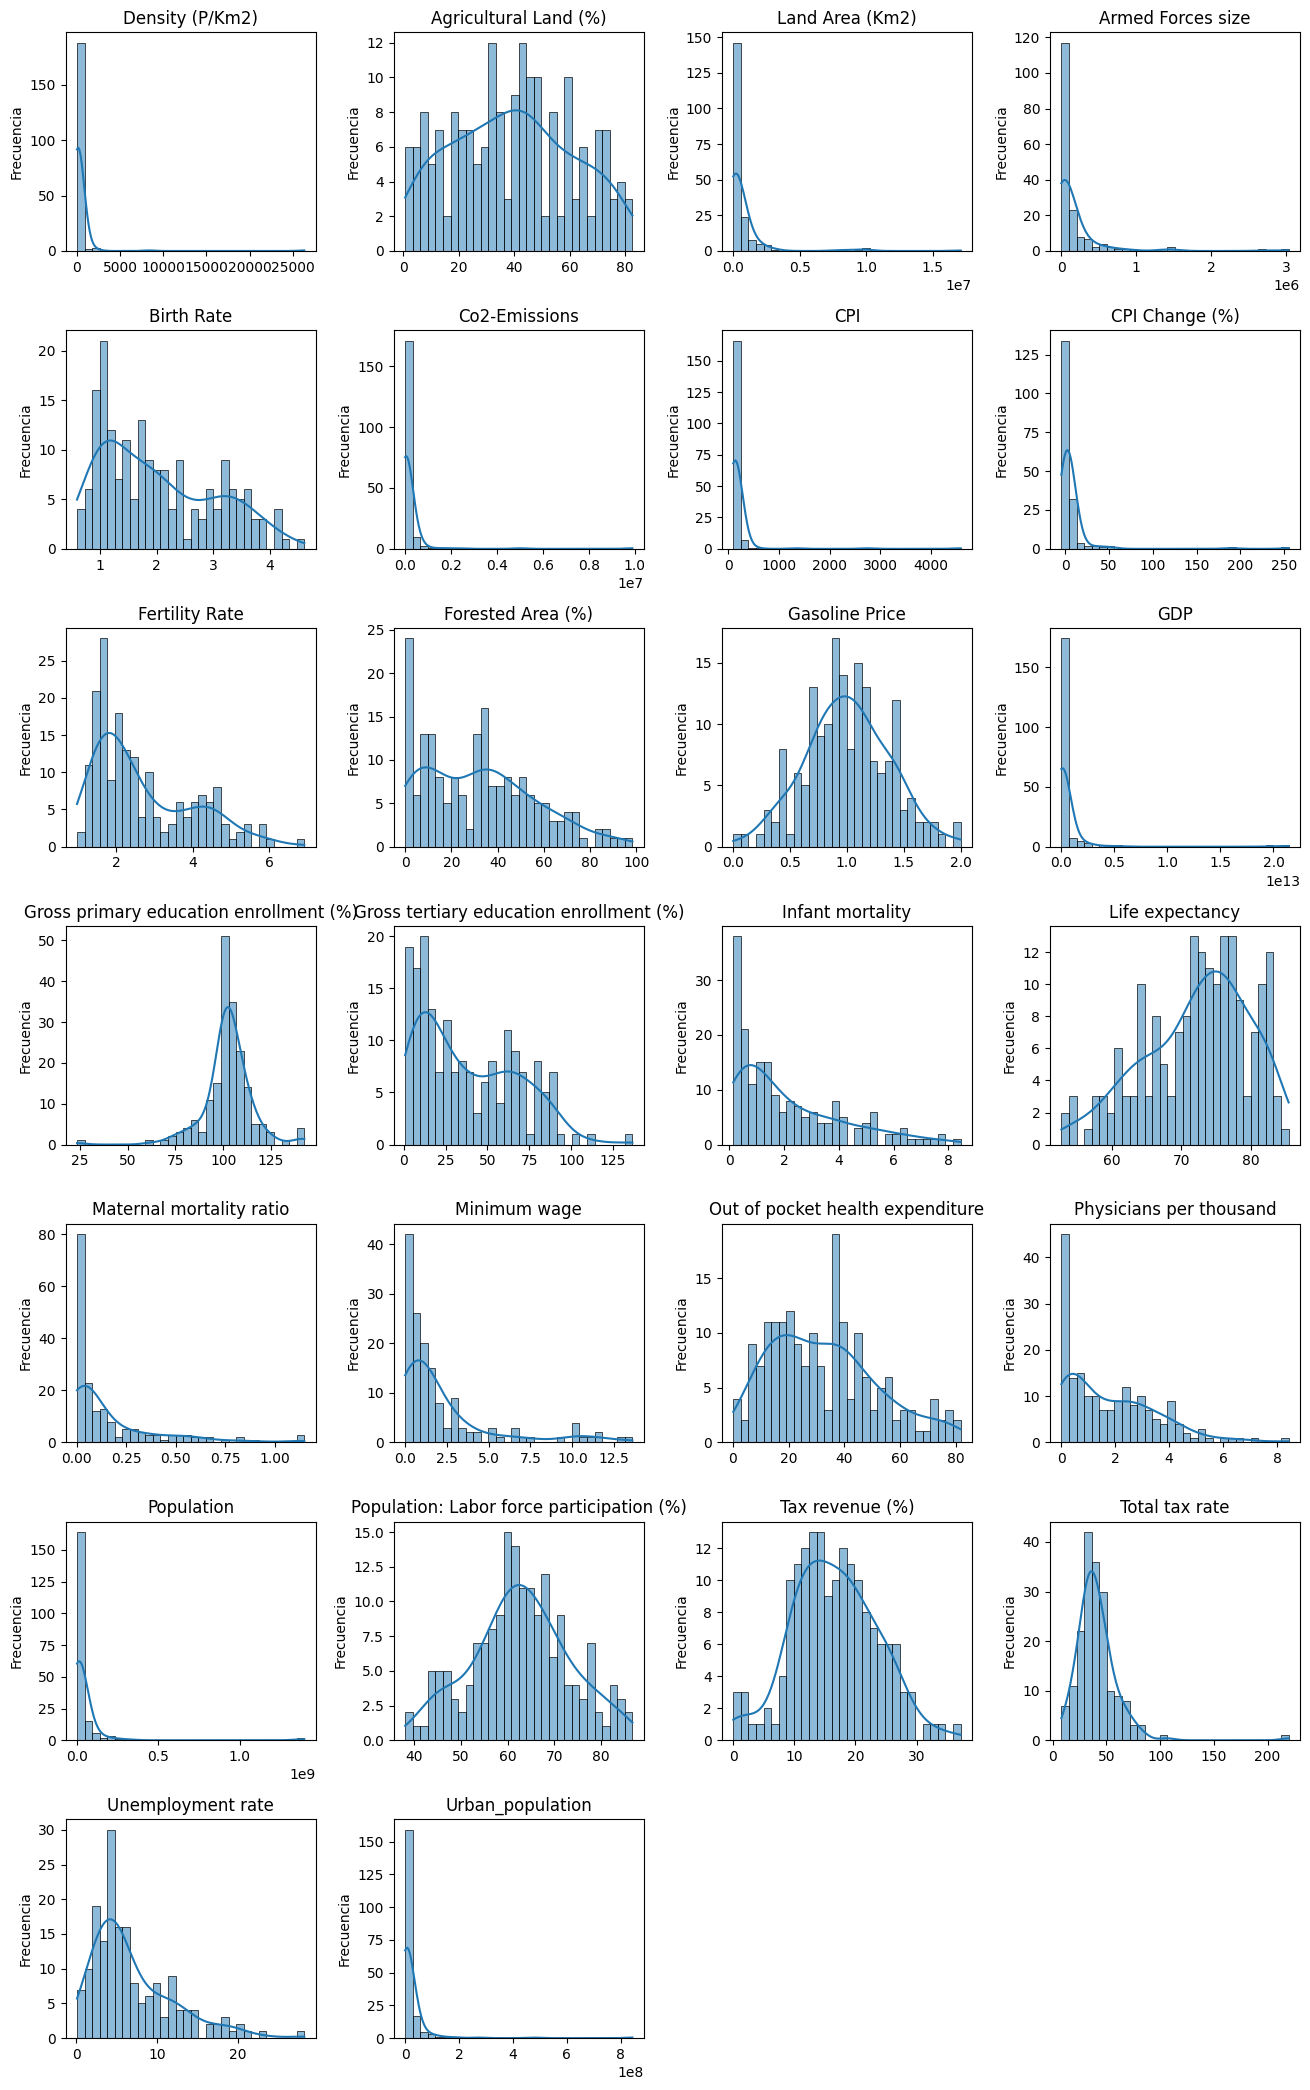

In [4]:
df_numeric = df.select_dtypes(include="number")

cols = df_numeric.columns

# Ajustes para plot
bins      = 30       # nº de barras por histograma
add_kde   = True     # curva KDE encima del histograma
wrap_cols = 4        # nº de subgráficas por fila
fig_h     = 3        # alto (pulgadas) de cada faceta
fig_aspect= 1.1      # ancho ≈ alto*aspect

# Rejilla
n_plots   = len(cols)
n_rows    = math.ceil(n_plots / wrap_cols)
fig_w     = wrap_cols * fig_h * fig_aspect

fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Histograma
for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], bins=bins, kde=add_kde, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Plotear Boxplot de los datos

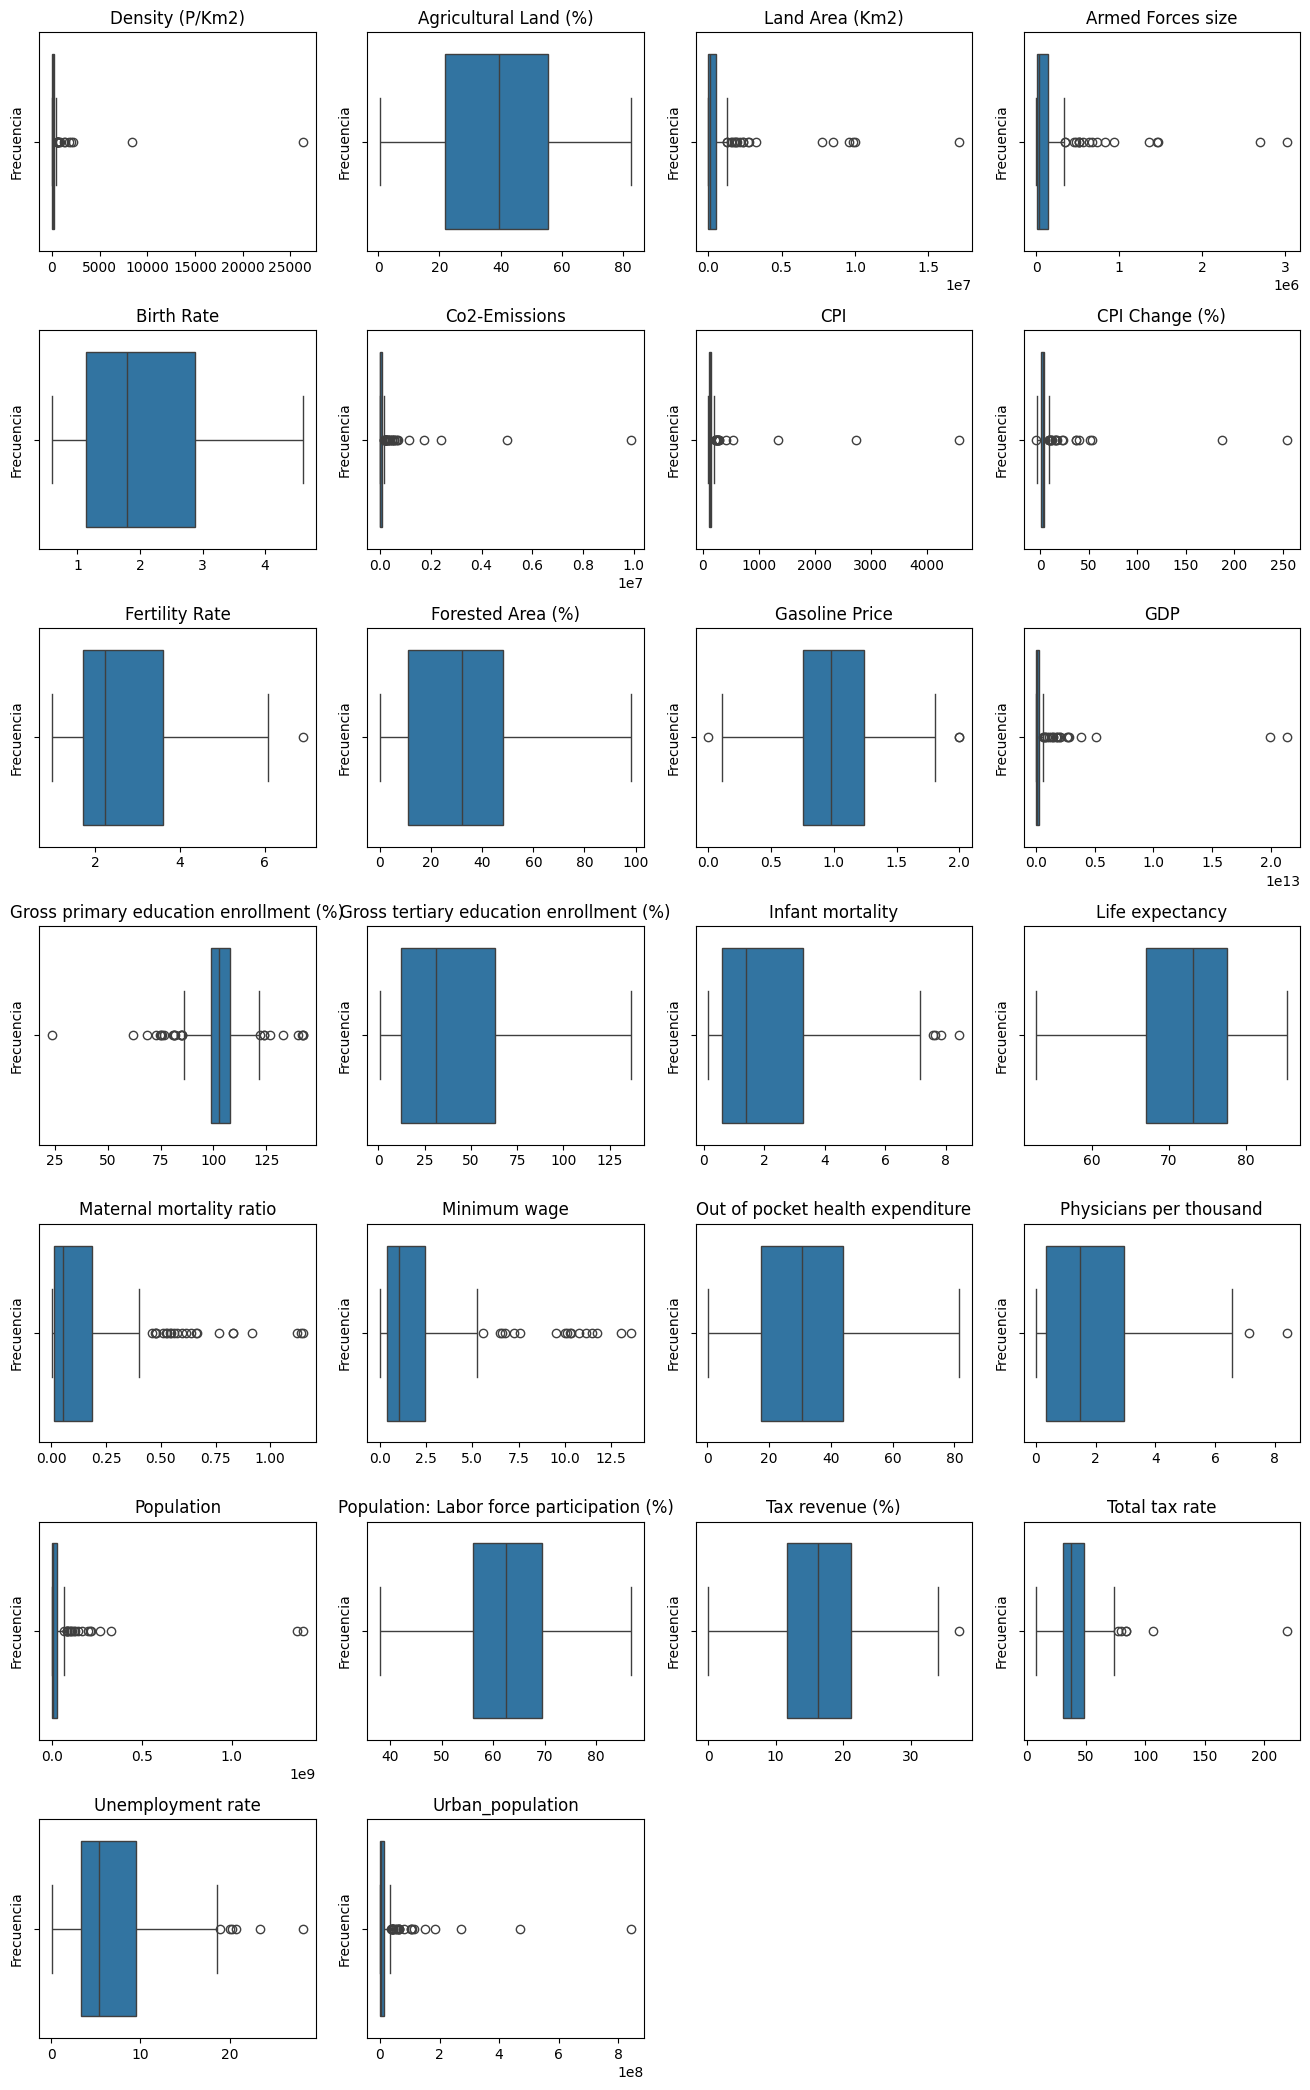

In [5]:
fig, axes = plt.subplots(n_rows, wrap_cols,
                         figsize=(fig_w, n_rows * fig_h),
                         sharex=False, sharey=False)

axes = axes.ravel()

# Plot Boxplot
for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")     # deja limpio o personaliza
    ax.set_ylabel("Frecuencia")

# Eliminar Celdas Vacias
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2. Correlación
De las variables codificadas numéricamente, ¿hay pares de ellas en la que parezca haber correlación? ¿Para cuál(es) de ellas se observa más claramente?

## 2.1 Graficar correlación
Primero para obtener la correlación entre las diferentes columnas se utiliza el método corr del dataframe de Pandas. Luego se utiliza la función heatmap de Seaborn en donde se entrega como parámetro la correlación obtenida en el paso anterior.

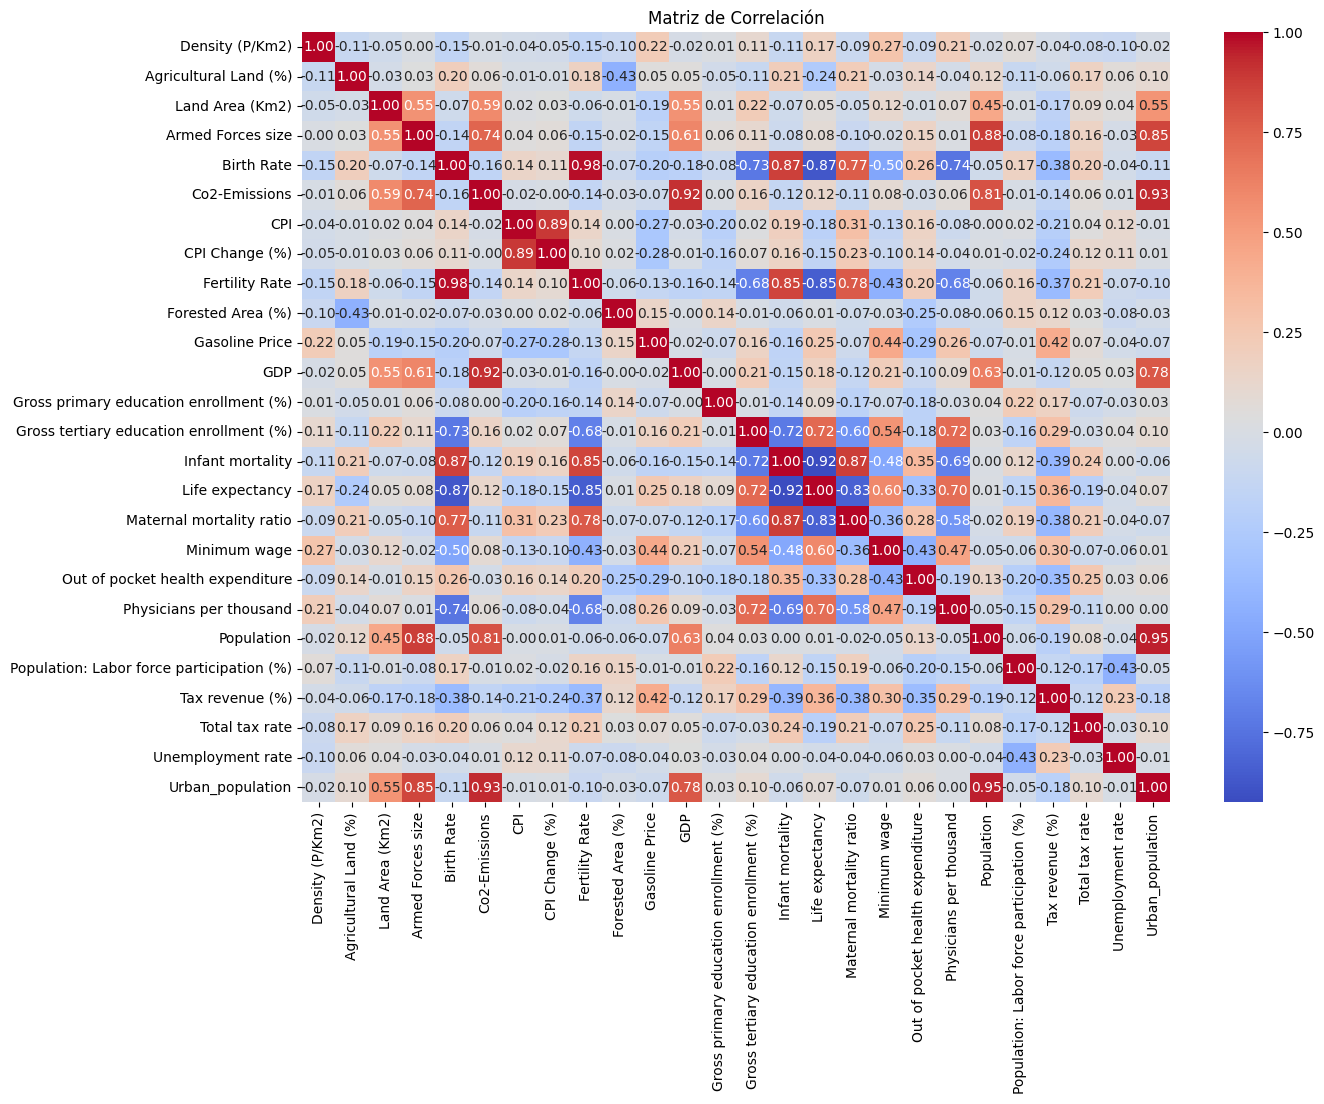

In [6]:
matriz_correlacion = df_numeric.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Del gráfico anterior se puede obtener los pares de mayor correlación, es decir, mayor a 0.9 o menor a -0.9:

- Birth rate y Fertility rate (0.98)
- C2-Emissions y GDP (0.92)
- C2-Emissions y Urban Population (0.93)
- Population y Urban Population (0.95)
- Life expactancy y Infant mnortality (-0.92)

Tambien es posible generar un gráfico que generé clusteres o conjuntos entre los de datos de las columnas que tienen una alta correlación.

<Figure size 1400x1000 with 0 Axes>

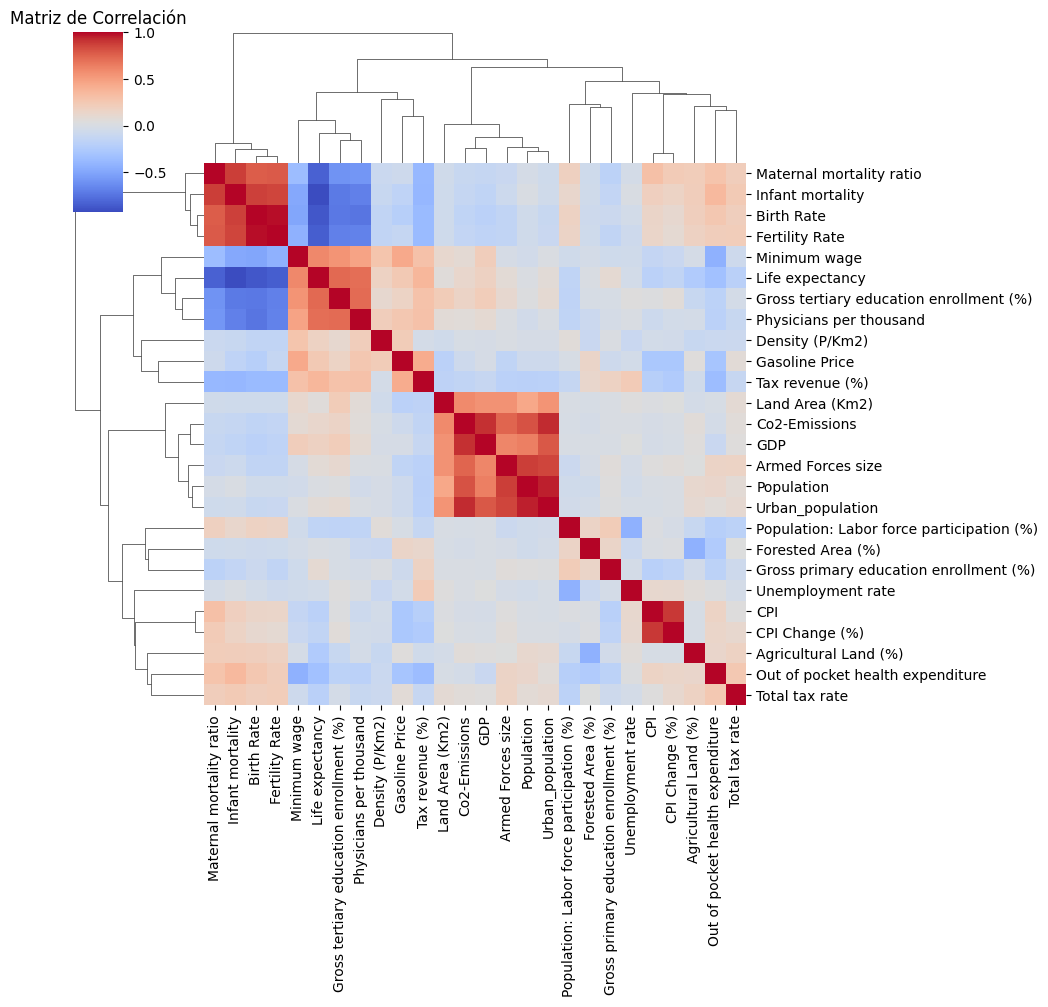

In [7]:
plt.figure(figsize=(14, 10))
sns.clustermap(matriz_correlacion, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

En el gráfico de correlación anterior se muestran los valores con mayor correlación (valores cenrcanos a 1) en rojo y de correlación negativa alta (valor cercanos a -1) en azul.

Del gráfico podemos concluir:

- Se generan al menos 4 clusteres donde existe una alta correlación:
  - Cluster 1:
    - Maternal mortality ratio
    - Infant mortality
    - Birth Rate
    - Fertility Rate
  - Cluster 2:
    - Life expectancy
    - Gross tertiary education enrollment (%)
    - Physicians per thousand
  - Cluster 3:
    - Land Area (Km2)
    - Co2-Emissions
    - GDP
    - Armed Forces size
    - Population
    - Urban population
  - Cluster 4:
    - CPI
    - CPI Change (%)
- En el cluster 1 las columnas se relacinan por datos de nacimiento
- En el cluster 2 las columnas se relacionan por educación. También se considera la espectativa de vida (Life expectancy) que se puede relacionar con la cantidad de médicos (Physicians per thousand)
- En el cluster 3 las columnas se relacionan por la cantidad de personas en cada país.
- En el cluster 4 las columnas se relacionan porque ambas son medidas o indicadores de inflación  
- Entre el cluster 1 y 2 existe una correlación negativa


## 3. Variables con mayor Correlación
Considera los dos pares de variables anteriores y elimina en cada caso los faltantes y atípicos. Justifica en cada caso tu procedimiento.

Los valores a utilizar son:

1. **Caso 1**: Birth Rate vs Fertility Rate
2. **Caso 2**: Life expectancy vs Infant mortality

Donde sus correlaciones son las que aperecen en el siguiente gráfico:

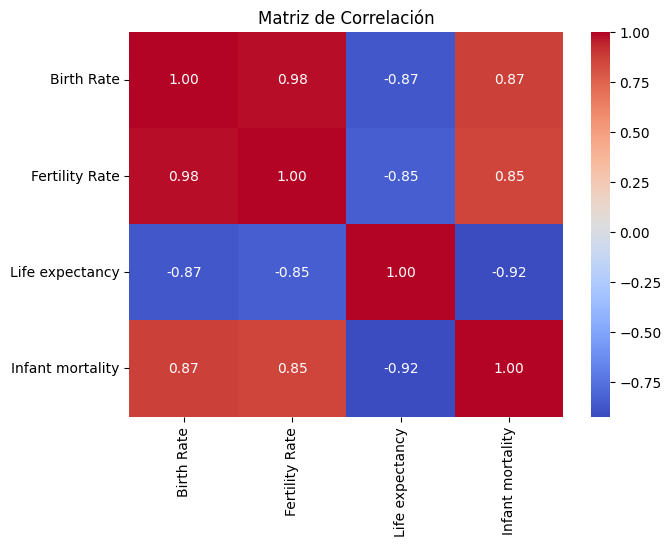

In [8]:
matriz_correlacion_mayor_v1 = df_numeric[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

## 3.1 Caso 1: Birth rate y Fertility rate

### 3.1.1 Caso 1: Outliers

Los datos faltantes ya fueron completados inputando la media. Para el caso de los outliers primero se utilizará el gráfico boxplot para identificar la existencia de estos valores atípicos:

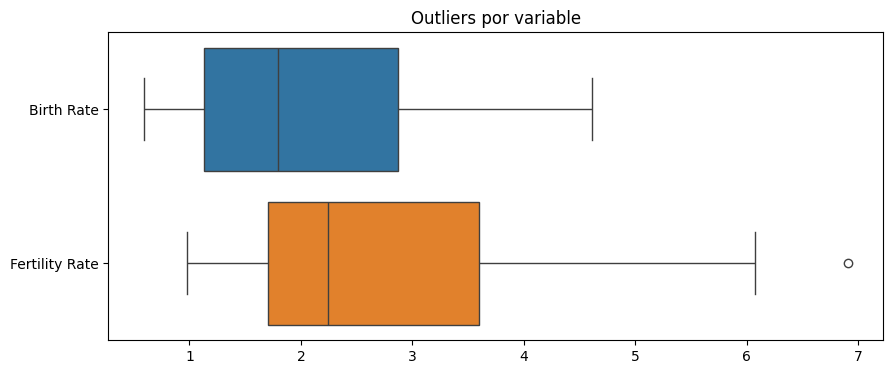

In [9]:
cols = ['Birth Rate', 'Fertility Rate']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols], orient='h')
plt.title("Outliers por variable")
plt.show()

En el gráfico anterior se observa la existencia de un outliers, para obtener la fila a la que corresponde se utiliza la función get_outliers:

In [10]:
print_outliers(df, cols)

Outliers:
Fertility Rate
    Country  Fertility Rate
125   Niger            6.91


El outliers proviene de Nigeria con una tasa de 6.91% según el criterio del rango intercuartil. Para no eliminar la fila completa se procede a imputar la media:

In [11]:
df.loc[125, 'Fertility Rate'] = df['Fertility Rate'].median()

### 3.1.2 Caso 1: Valores Nulos

Para los valores faltantes se tomará el porcentaje de nulos por columna y si es menor a 40% se inputará la media, de caso contrario se emputara (eliminara) las filas con valores nulos en las columnas procesadas. ([Link Justificación criterio 40%](https://pmc.ncbi.nlm.nih.gov/articles/PMC6293424/))

In [12]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Fertility Rate,3.59
Birth Rate,3.08


Como el porcentaje de nulos de todas las columnas es menor al 40% se procede a imputar la media en los datos faltantes de cada columna

In [13]:
imp_num = SimpleImputer(strategy="median") # Se carga la clase para procesar las imputaciones
df[cols] = imp_num.fit_transform(df[cols]) # Se imputa la media

## 3.2 Caso 2: Life expactancy y Infant mortality


### 3.2.1 Caso 2: Outliers

Los datos faltantes ya fueron completados inputando la media. Para el caso de los outliers primero se utilizará el gráfico boxplot para identificar la existencia de estos valores atípicos:

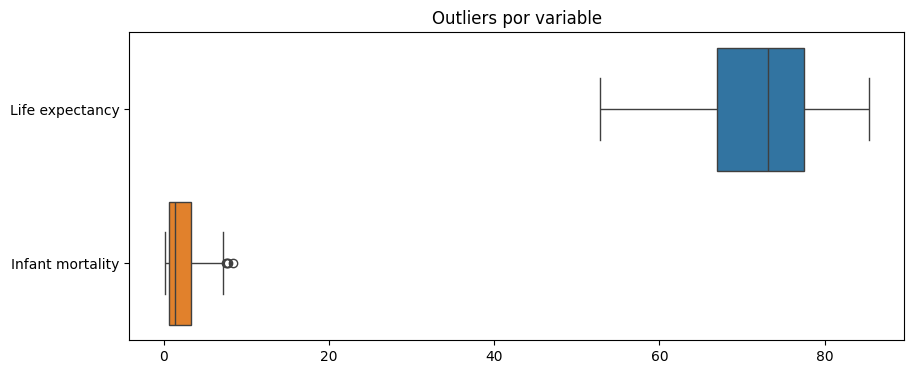

In [14]:
cols_2 = ['Life expectancy', 'Infant mortality']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_2], orient='h')
plt.title("Outliers por variable")
plt.show()

Aplicando la misma función anterior para obtener los outliers:

In [15]:
print_outliers(df, cols_2)

Outliers:
Infant mortality
                      Country  Infant mortality
33   Central African Republic              8.45
126                   Nigeria              7.57
155              Sierra Leone              7.85
160                   Somalia              7.66


En esta comparación se cuentran 5 outliers según el criterio de la **regla del rango intercuartil**. Para no eliminar las filas completas se procede a imputar la media:

In [16]:
for i in [33, 126, 155, 160]:
  df.loc[i, 'Infant mortality'] = df['Infant mortality'].median()

### 3.2.2 Caso 2: Valores Nulos

Aplicando el mismo criterio anterior del 40%, de nulos se procede a calcular el porcentaje:

In [17]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols_2].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Life expectancy,4.10
Infant mortality,3.08


Como el porcentaje de nulos de todas las columnas es menor al 40% se procede a imputar la media en los datos faltantes de cada columna

In [18]:
imp_num = SimpleImputer(strategy="median") # Se carga la clase para procesar las imputaciones
df[cols_2] = imp_num.fit_transform(df[cols_2]) # Se imputa la media


## 4. Gráfico entre variables
Construye un gráfico para verificar la correlación entre estas variables, ahora con los datos preparados. Compara con lo obtenido anteriormente.

El nuevo gráfico de correlación obtenido es el siguiente:

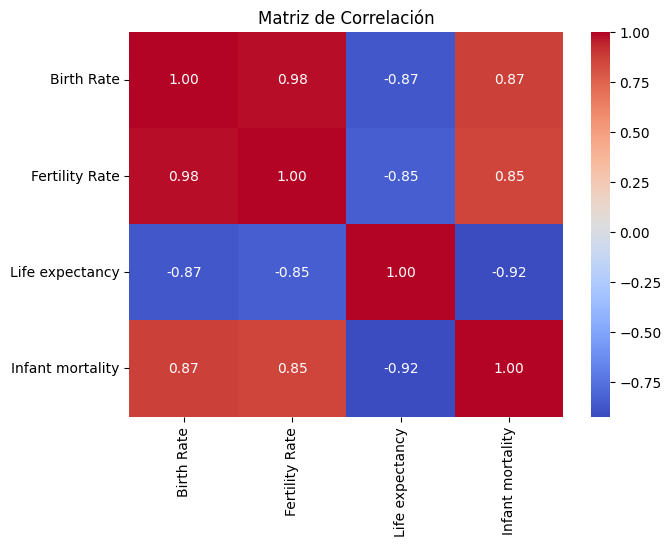

In [19]:
matriz_correlacion_mayor_v2 = df_numeric[['Birth Rate', 'Fertility Rate', 'Life expectancy', 'Infant mortality']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

De este gráfico se puede concluir que la eliminación de los outliers no tuvo un efecto significativo (considerando que solo se obtiene 2 cifras decimales) en las correlación de los datos.

Respecto a los outliers, en el primer caso y gráficando nuevamente con boxplot no se observan outliers. Sin embargo, en el caso 2 si se observan nuevos outliers esto debido a que los datos de Infant mortality están muy centrados cerca de cero y su cola de distribución hacia la derecha es muy larga.

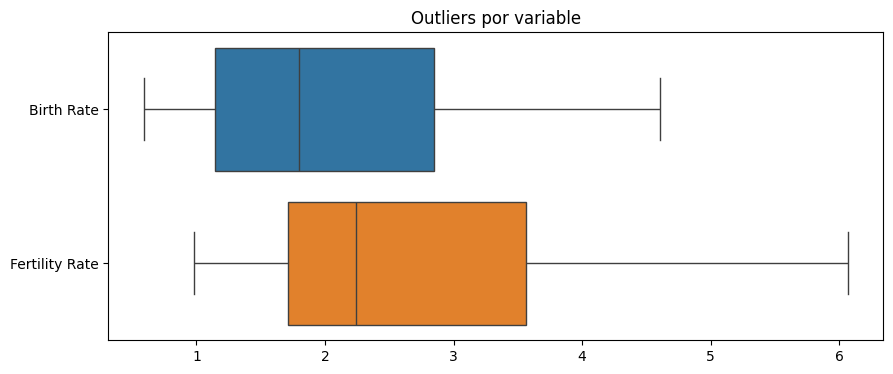

In [20]:
cols = ['Birth Rate', 'Fertility Rate']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols], orient='h')
plt.title("Outliers por variable")
plt.show()

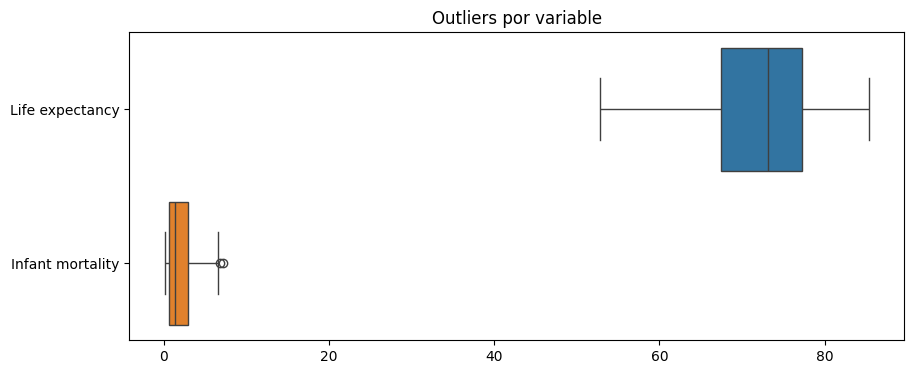

In [21]:
cols_2 = ['Life expectancy', 'Infant mortality']
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_2], orient='h')
plt.title("Outliers por variable")
plt.show()

In [22]:
get_outliers(df, cols_2)

,Infant mortality
0,False
1,False
2,False
3,False
4,False
...,...
190,False
191,False
192,False
193,False


## 5. Médicos y esperanza de vida
Realiza lo mismo para comparar la cantidad de médicos por cada mil personas y la esperanza de vida. ¿Qué puedes concluir?

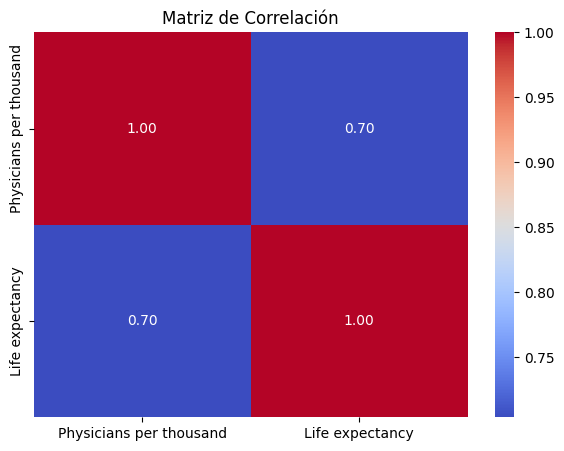

In [23]:
cols_3 = ['Physicians per thousand', 'Life expectancy']
matriz_correlacion_mayor_v3 = df_numeric[cols_3].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v3, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [24]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols_3].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
Physicians per thousand,3.59
Life expectancy,0.00


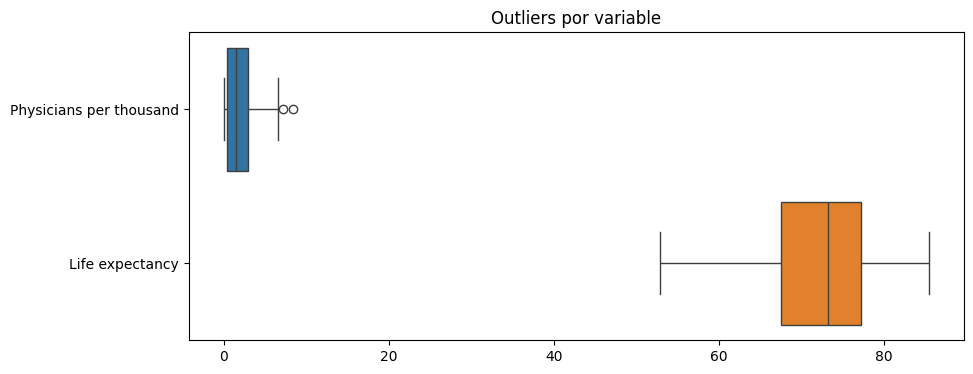

In [25]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_3], orient='h')
plt.title("Outliers por variable")
plt.show()

## 6. Población países
Construye un gráfico para representar la población total de los países y su producto interno bruto. Prepara los datos y escoge el gráfico adecuado (si es necesario, limpia y/o transforma los datos). Justifica.

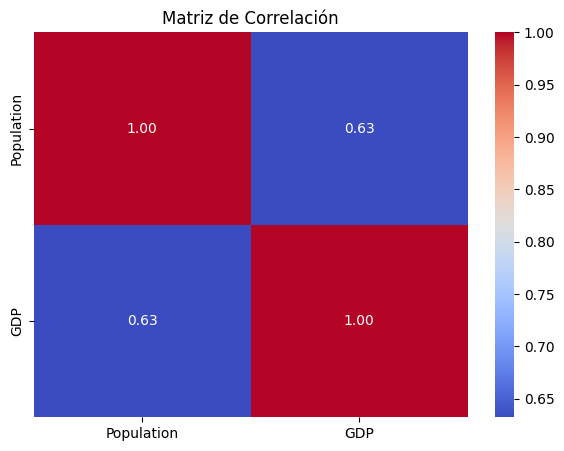

In [26]:
cols_4 = ['Population', 'GDP']
matriz_correlacion_mayor_v4 = df_numeric[cols_4].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion_mayor_v4, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [27]:
# Para determinar si se debe imputar o amputar los datos faltantes se obtiene el porcentaje de nulos por columna
df[cols_4].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False) / len(df) * 100

,0
GDP,1.03
Population,0.51


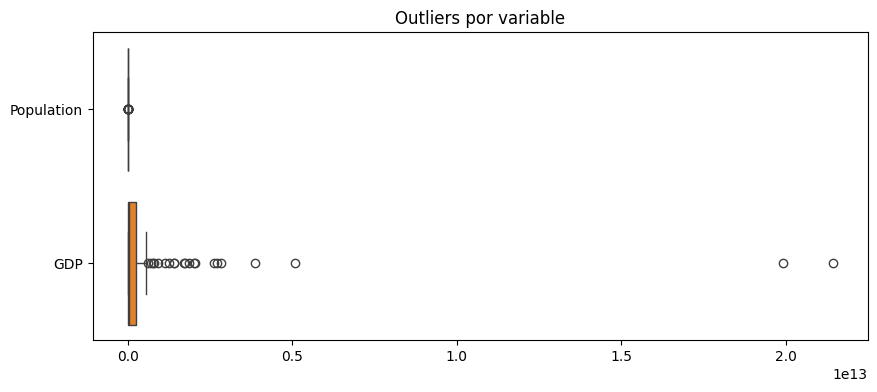

In [28]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df[cols_4], orient='h')
plt.title("Outliers por variable")
plt.show()

In [29]:
# Valores extremos
extremos = get_outliers(df, cols_4, 3)

In [30]:
df_sin_extremos = df.drop(df[extremos].index)



In [31]:
print_outliers(df_sin_extremos, cols_4, 3)


Outliers:
Population
                              Country     Population
45   Democratic Republic of the Congo  86,790,567.00
51                              Egypt 100,388,073.00
79                               Iran  82,913,906.00
138                       Philippines 108,116,615.00
173                          Thailand  69,625,582.00
179                            Turkey  83,429,615.00
191                           Vietnam  96,462,106.00
GDP
                  Country                GDP
6               Argentina 449,663,446,954.00
9                 Austria 446,314,739,528.00
16                Belgium 529,606,710,418.00
79                   Iran 445,345,282,123.00
81    Republic of Ireland 388,698,711,348.00
82                 Israel 395,098,666,122.00
103              Malaysia 364,701,517,788.00
122           Netherlands 909,070,395,161.00
129                Norway 403,336,363,636.00
138           Philippines 376,795,508,680.00
139                Poland 592,164,400,688.00
151        

In [34]:
df2 = escalado_robusto(df_sin_extremos, cols_4)

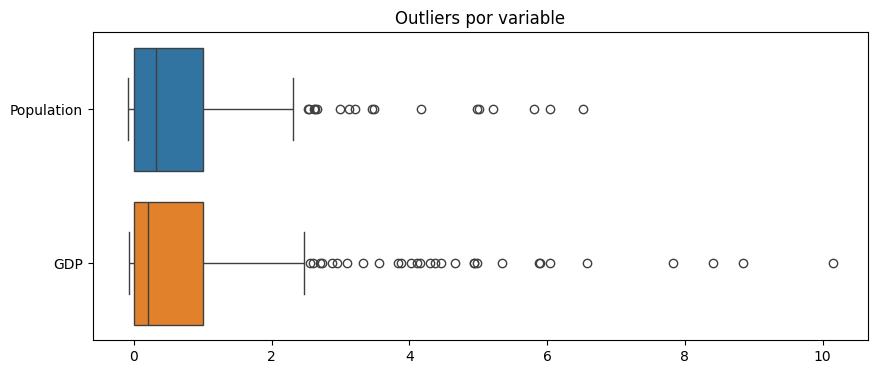

In [35]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df2[cols_4], orient='h')
plt.title("Outliers por variable")
plt.show()

## 7. Otros datos
Escoge otro par de datos, límpialos, prepáralos y analiza su posible relación. Justifica utilizando las herramientas vistas y gráficos adecuados.